# Setup 

In [1]:
%matplotlib inline

import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision import datasets, transforms

## Args and random seed

In [2]:
class args_c():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 2
        self.lr = 0.01 
        self.momentum = 0.5
        self.seed = 1
        self.log_interval = 1
        
args = args_c()

In [3]:
torch.manual_seed(args.seed); #random seed

## Dataloaders

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,)) #normalise pixels using mean and stdev
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalise to range -1 to 1
                   ])



MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', train=True, download=True,
                   transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', train=False, download=True,
                   transform=transform)

In [5]:
train_loader = torch.utils.data.DataLoader(MNIST_train, 
                                           batch_size=args.batch_size, 
                                           shuffle=True, 
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                                          batch_size=args.test_batch_size, 
                                          shuffle=True, 
                                          pin_memory=True)

## Network definition

In [6]:
class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
model = NNet().cuda()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

## Train

In [8]:
#criterion = nn.CrossEntropyLoss()

In [9]:
def train(args, model, train_loader, optimizer, epoch):
    
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data.cuda()), Variable(target.cuda())
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward() 
        optimizer.step()
        running_loss += loss.item()

    running_loss /= len(train_loader.dataset)    
    
    if epoch % args.log_interval == 0:
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, running_loss ))

In [10]:
def test(args, model, test_loader):
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        
        for data, target in test_loader:
            
            data, target = data.cuda(), target.cuda()
            output = model(data)
            
            test_loss += F.nll_loss(output, target, size_average=False).item()
            
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
def run():
    for epoch in range(1, args.epochs + 1):
        train(args, model, train_loader, optimizer, epoch)
        test(args, model, test_loader)

In [12]:
#run()

## Save model

In [13]:
fp = r"D:\Models\MNIST\110718"
#torch.save(model.state_dict(), fp)
model.load_state_dict(torch.load(fp))

# FGSM

In [14]:
grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [46]:
def fgsm(model, x, y, eps=0.03, x_val_min=-1, x_val_max=1, batch=True): #https://arxiv.org/pdf/1412.6572.pdf
    
    x_adv = Variable(x.data, requires_grad=True).cuda() #clean image
    x_adv.register_hook(save_grad('x_adv'))
    
    h_adv = model(x_adv) #clean pred
    
    cost = F.nll_loss(h_adv, y.cuda()) #cross entropy loss clean image and clean pred

    if x_adv.grad is not None:
        x_adv.grad.data.fill_(0)

    cost.backward()

    #x_adv.grad.sign_() #take sign of gradients 
    x_adv = x_adv + (eps*grads['x_adv'].sign())
    x_adv = torch.clamp(x_adv, x_val_min, x_val_max)
    
    if batch == False:
        with torch.no_grad():
            h = model(x)
            h_adv = model(x_adv)

        return x_adv, h_adv, h
    
    return x_adv

In [16]:
unbatch = next(iter(train_loader))

xx = unbatch[0][5].view(1,1,28,28).cuda()
yy = unbatch[1][5].view(1).cuda()

In [42]:
def adv_plotter(x, y, model, eps=0.3):
    
    x_adv, h_adv, h = fgsm(model, x, y, eps=eps, batch=False)
    
    x = x.cpu().detach().numpy().reshape(28,28)
    x_adv = x_adv.cpu().detach().numpy().reshape(28,28)
    
    clean_h = h
    adv_h = h_adv
    
    cleanpred = F.softmax(clean_h).argmax()
    advpred = F.softmax(adv_h).argmax()
    
    cleanpredpct = F.softmax(clean_h).max()
    advpredpct = F.softmax(adv_h).max()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,10))
    ax1.imshow(x, cmap='Greys')
    ax1.text(x=3, y=32, s="Predicted: {x:.0f} ({y:.2f})".format(x=cleanpred, y=cleanpredpct), fontsize=20)
    ax2.imshow(x_adv, cmap='Greys')
    ax2.text(x=3, y=32, s="Predicted: {x:.0f} ({y:.2f})".format(x=advpred, y=advpredpct), fontsize=20)
    ax3.imshow(x - x_adv, cmap='Greys')
    ax3.text(x=8, y=32, s="Difference", fontsize=20)

C:\Users\James\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\James\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\James\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\James\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


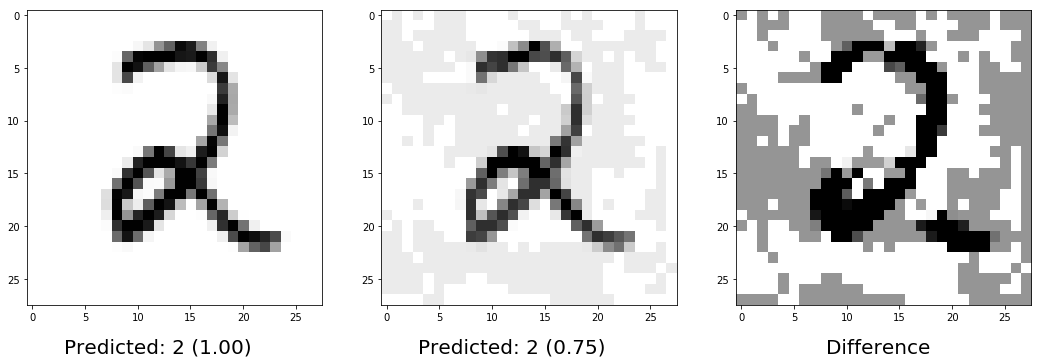

In [43]:
adv_plotter(xx, yy, model, eps=0.3)

In [55]:
def advtester(model, dataloader, eps):
    
    correct = 0
    
    for data, target in dataloader:
            
            data= fgsm(model, data, target, eps=eps)
            
            output = model(data)
            
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred).cuda()).sum().item()
            
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print('Accuracy on adversarial examples: {}/{} ({:.1f}%)\n'.format(
    correct, len(test_loader.dataset),accuracy))
    
    return accuracy

In [56]:
advtester(model, test_loader, eps=0.9)

Accuracy on adversarial examples: 20/10000 (0.2%)



0.2